# Evaluation for trained model to decode 32 bits polar code 

In [1]:
import sys, pathlib

p = pathlib.Path.cwd()
while p != p.parent:
    if (p / "models").exists():
        project_root = p
        break
    p = p.parent

sys.path.insert(0, str(project_root))

In [2]:
import re, matplotlib.pyplot as plt, os

In [3]:
import torch
from dataset import PolarDecDataset 
from models.wrappers.mamba_32bits import MambaPolarDecoder

from torch.utils.data import DataLoader

/home/anjal/Desktop/Code/mamba-seq-pred/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
N = 32

In [6]:
model = MambaPolarDecoder(
    d_model=64,
    num_layer_encoder=1,
    num_layers_bimamba_block=32,
    seq_len=N,
    d_state=32,
    d_conv=4,
    expand=2
).to(device)
model

MambaPolarDecoder(
  (discrete_embedding): Embedding(2, 64)
  (linear_embedding1): Linear(in_features=1, out_features=64, bias=True)
  (linear_embedding2): Linear(in_features=1, out_features=64, bias=True)
  (encoder_layers): ModuleList(
    (0): BiMambaEncoder(
      (layers): ModuleList(
        (0-31): 32 x BiMambaBlock(
          (pre_ln_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (mamba_f): Mamba(
            (in_proj): Linear(in_features=64, out_features=256, bias=False)
            (conv1d): Conv1d(128, 128, kernel_size=(4,), stride=(1,), padding=(3,), groups=128)
            (act): SiLU()
            (x_proj): Linear(in_features=128, out_features=68, bias=False)
            (dt_proj): Linear(in_features=4, out_features=128, bias=True)
            (out_proj): Linear(in_features=128, out_features=64, bias=False)
          )
          (post_ln_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (ffn_f): Sequential(
            (0): Linear(in_f

In [7]:
ckpt_path = "../checkpoints/model_epoch_2.pt" 

In [8]:
ckpt = torch.load(ckpt_path, map_location=device)
ckpt

{'epoch': 3,
 'train_loss': 0.24970011699199676,
 'val_loss': tensor(0.2397, device='cuda:0'),
 'state_dict': OrderedDict([('alpha', tensor(0.0349, device='cuda:0')),
              ('beta', tensor(-0.0010, device='cuda:0')),
              ('gamma', tensor(0.4047, device='cuda:0')),
              ('discrete_embedding.weight',
               tensor([[-0.0032, -0.0033, -0.0033, -0.0032, -0.0033, -0.0008, -0.0032, -0.0032,
                        -0.0033, -0.0032, -0.0032, -0.0032, -0.0032, -0.0032, -0.0032, -0.0033,
                        -0.0033, -0.0033, -0.0032, -0.0033, -0.1586, -0.0032, -0.0033, -0.0032,
                        -0.0032, -0.0033, -0.0032, -0.0033, -0.0032, -0.0032, -0.0033, -0.0032,
                        -0.0033, -0.0032, -0.0032, -0.0033, -0.0033, -0.0032, -0.0032, -0.0032,
                        -0.0033, -0.0032, -0.0033, -0.0033, -0.0032,  0.0455, -0.0033, -0.0033,
                        -0.0032, -0.0033, -0.0033, -0.0032, -0.0032, -0.0033, -0.0032, -0.0032,
 

### Loss Trend

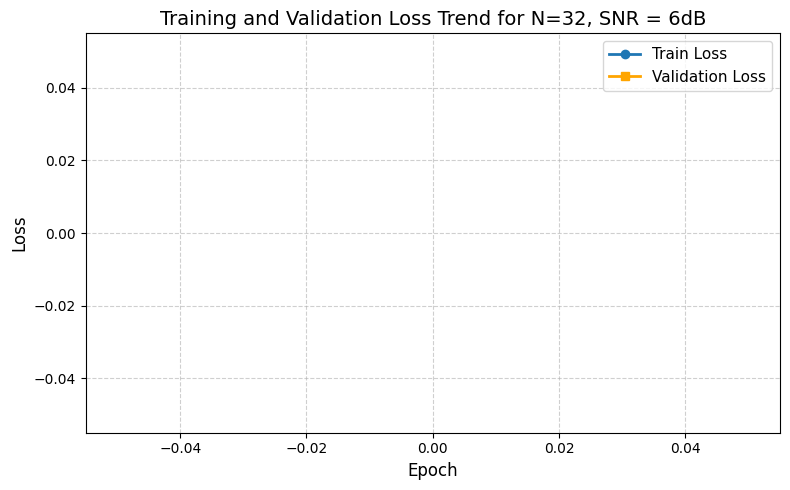

In [9]:
ckpt_dir = pathlib.Path("../checkpoints")  
pattern = re.compile(r"model_epoch_(\d+)\.pt$")

records = []

# load (epoch, train_loss, valid_loss)
for ckpt_file in ckpt_dir.glob("model_epoch_*.pt"):
    m = pattern.search(ckpt_file.name)
    if not m:
        continue
    epoch = int(m.group(1))
    ckpt = torch.load(ckpt_file, map_location="cpu")
    train_loss = ckpt.get("train_loss")
    valid_loss = ckpt.get("valid_loss")
    if train_loss is not None and valid_loss is not None:
        records.append((epoch, train_loss, valid_loss))


records.sort(key=lambda x: x[0])

epochs = [r[0] for r in records]
train_losses = [r[1] for r in records]
valid_losses = [r[2] for r in records]


plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, marker='o', label='Train Loss', linewidth=2)
plt.plot(epochs, valid_losses, marker='s', label='Validation Loss', linewidth=2, color='orange')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training and Validation Loss Trend for N=32, SNR = 6dB", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()



### Metrics

In [10]:
ckpt = torch.load(os.path.join(ckpt_dir, "model_epoch_2.pt"), map_location=device)

# load model
state_dict = ckpt.get("model_state_dict", ckpt.get("state_dict", ckpt))
model.load_state_dict(state_dict, strict=False)

<All keys matched successfully>

In [11]:
test_set = PolarDecDataset(snr_db=6, num_samples=32000)
test_dataloader = DataLoader(test_set, batch_size = 32)

In [20]:
channel_tensor, frozen_tensor, snr_tensor, target_tensor= next(iter(test_dataloader))
ip1 = channel_tensor.float().to(device)
ip2 = frozen_tensor.int().to(device)
ip3 = snr_tensor.float().to(device)


predicted = model(ip1, ip2, ip3) #works

 #loss = calculate_loss_for_reliable_bits_only(ip2, target_tensor.to(device), predicted.to(device), loss_fn) #works


print(f"Channel Observation Vector: {ip1.shape}\nFrozen Tensor: {ip2.shape}\n")
print(f"Predicted Channel Input Vector(logits): {predicted.shape}\n\n")

print(f"Predicted (sigmoid): {torch.sigmoid(predicted)}\n\n")
pred = (torch.sigmoid(predicted) > 0.5).long()[0]

print(f"Predicted bits:{''.join(map(str, pred.cpu().tolist()))}\n")
print(f"Actual bits: {''.join(str(int(i)) for i in target_tensor[0])}\n")
#print(f"Loss: {loss}")

Channel Observation Vector: torch.Size([32, 32])
Frozen Tensor: torch.Size([32, 32])

Predicted Channel Input Vector(logits): torch.Size([32, 32])


Predicted (sigmoid): tensor([[0.5341, 0.5382, 0.5415,  ..., 0.0019, 0.2995, 0.5135],
        [0.5195, 0.1343, 0.9539,  ..., 0.0019, 0.0503, 0.5132],
        [0.5019, 0.2825, 0.9145,  ..., 0.0069, 0.4908, 0.4948],
        ...,
        [0.5324, 0.4309, 0.4971,  ..., 0.0070, 0.3950, 0.5048],
        [0.5385, 0.3914, 0.6064,  ..., 0.0136, 0.0642, 0.5193],
        [0.5112, 0.5342, 0.8696,  ..., 0.5214, 0.4460, 0.5050]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)


Predicted bits:11111010101010001000000010100001

Actual bits: 01010010001010000000000010000000



In [21]:


def calc_ber(test_loader, model, device):
    """
    Calculate BER over a test dataset considering only non-frozen bits.

    Args:
        test_loader: PyTorch DataLoader providing (channel, frozen, snr, target)
        model: your trained model
        device: torch device (cpu or cuda)
    
    Returns:
        float: average BER over the test set
    """
    total_bit_errors = 0
    total_bits = 0

    model.eval()
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            channel_tensor, frozen_tensor, snr_tensor, target_tensor = data
            
            # Move to device
            ip1 = channel_tensor.float().to(device)
            ip2 = frozen_tensor.int().to(device)
            ip3 = snr_tensor.float().to(device)
            op = target_tensor.int().to(device)

          #  print(ip3.shape)

            # Forward pass
            predicted_vector = model(ip1, ip2, ip3)

            # Threshold predictions if they are probabilities/logits
            if predicted_vector.dtype != torch.bool and predicted_vector.dtype != torch.int:
                predicted_vector = (predicted_vector > 0.5).int()

            # Mask for reliable (non-frozen) bits
            mask = (ip2 != 1)
            reliable_target = op[mask]
            reliable_predicted = predicted_vector[mask]

            # Compute bit errors and accumulate
            bit_errors = (reliable_target != reliable_predicted).sum().item()
            total_bit_errors += bit_errors
            total_bits += reliable_target.numel()

    # Average BER
    ber = total_bit_errors / total_bits if total_bits > 0 else 0.0
    return ber


In [22]:
ber = calc_ber(test_dataloader, model, device)
ber

0.21275488728837338